In [25]:
import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from google.cloud import bigquery, storage
import os

# Configura tu proyecto y variables de BigQuery
project_id = "liverpoolsku-439723"
vertexai.init(project=project_id, location="us-central1")

# Variables de configuración
BUCKET_NAME = "mi-bucket-de-imagenes1"
DATASET_ID = "image_dataset"
TABLE_ID = "image_embeddings"
LOCAL_DOWNLOAD_PATH = "/tmp"

# Inicializar el cliente de BigQuery y Storage
bigquery_client = bigquery.Client(project=project_id)
storage_client = storage.Client(project=project_id)

# Cargar el modelo de Gemini Vision para embeddings
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

def generate_and_store_embeddings(bucket_name, dataset_id, table_id):
    # Crear el dataset y la tabla en BigQuery si no existen
    dataset_ref = bigquery_client.dataset(dataset_id)
    table_ref = dataset_ref.table(table_id)

    schema = [
        bigquery.SchemaField("image_uri", "STRING"),
        bigquery.SchemaField("embedding", "FLOAT64", mode="REPEATED"),
    ]
    table = bigquery.Table(table_ref, schema=schema)
    bigquery_client.create_table(table, exists_ok=True)

    # Listar y procesar cada imagen en el bucket
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs()

    for blob in blobs:
        if blob.name.endswith(('.jpg', '.jpeg', '.png')):  # Filtrar solo imágenes
            image_uri = f"gs://{bucket_name}/{blob.name}"
            print(f"Procesando imagen: {image_uri}")

            # Descargar la imagen localmente
            local_image_path = os.path.join(LOCAL_DOWNLOAD_PATH, blob.name)
            blob.download_to_filename(local_image_path)

            # Crear objeto de imagen para Vertex AI desde el archivo local
            image_part = Image.load_from_file(local_image_path)

            # Generar embeddings
            image_embedding = model.get_embeddings(
                image=image_part,
                dimension=128  # Cambiar dimensión según necesidad
            ).image_embedding

            # Insertar en BigQuery
            rows_to_insert = [
                {
                    "image_uri": image_uri,
                    "embedding": list(image_embedding),  # Convierte el embedding a lista
                }
            ]
            errors = bigquery_client.insert_rows_json(table_ref, rows_to_insert)
            if errors:
                print(f"Errores al insertar en BigQuery: {errors}")
            else:
                print(f"Embeddings de {image_uri} almacenados en BigQuery.")

            # Eliminar la imagen local para liberar espacio
            os.remove(local_image_path)


In [26]:
from google.cloud import bigquery
import numpy as np

# Parámetros de configuración
project_id = "liverpoolsku-439723"
dataset_id = "image_dataset"
table_id = "image_embeddings"
bigquery_client = bigquery.Client(project=project_id)

def find_similar_images(query_embedding, top_k=5):
    # Convertir el embedding a formato adecuado para SQL
    embedding_str = ",".join(map(str, query_embedding))

    # Consulta de BigQuery para encontrar las imágenes más similares
    query = f"""
    SELECT
        image_uri,
        SQRT(SUM(POW(embedding_value - query_value, 2))) AS distance
    FROM
        `{project_id}.{dataset_id}.{table_id}`,
        UNNEST(embedding) AS embedding_value WITH OFFSET AS index1,
        UNNEST([ARRAY<{len(query_embedding)}>]({embedding_str})) AS query_value WITH OFFSET AS index2
    WHERE
        index1 = index2
    GROUP BY
        image_uri
    ORDER BY
        distance ASC
    LIMIT
        {top_k}
    """

    # Ejecutar la consulta
    query_job = bigquery_client.query(query)
    results = query_job.result()


In [ ]:
# Install required packages
!pip install torch torchvision google-cloud-bigquery google-cloud-storage

# Import necessary libraries
from google.colab import files
from google.cloud import storage, bigquery
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np

# Step 1: Upload your JSON credentials
uploaded_credentials = files.upload()  # Upload credentials file
credentials_file = list(uploaded_credentials.keys())[0]

# Set up authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_file

# Step 2: Upload the image file
uploaded_image = files.upload()  # Upload image to GCS
local_image_path = list(uploaded_image.keys())[0]

# Step 3: Configure bucket and file name
BUCKET_NAME = "mi-bucket-de-imagenes1"
REMOTE_FILE_NAME = "nombre_en_gcs.jpg"  # Set remote GCS name

# Function to upload file to GCS
def upload_single_file_to_gcs(bucket_name, local_file_path, remote_file_name):
    storage_client = storage.Client()  # Use default credentials
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(remote_file_name)
    blob.upload_from_filename(local_file_path)
    print(f"File '{local_file_path}' uploaded to '{bucket_name}/{remote_file_name}'.")

# Upload the image
upload_single_file_to_gcs(BUCKET_NAME, local_image_path, REMOTE_FILE_NAME)

# Load a pre-trained model (e.g., ResNet-50) for embeddings
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last layer for embeddings
model.eval()

# Define the preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
input_image = Image.open(local_image_path).convert("RGB")  # Ensure image is in RGB mode
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create mini-batch

# Generate the embedding
with torch.no_grad():
    embedding = model(input_batch).flatten().numpy()

# Convert the embedding into a list format
embedding_list = embedding.tolist()

# Insert the embedding into BigQuery
table_id = "liverpoolsku-439723.image_dataset.image_embeddings"  # Replace with your table ID
client = bigquery.Client()
rows_to_insert = [{"image_path": local_image_path, "embedding": embedding_list}]
errors = client.insert_rows_json(table_id, rows_to_insert)

if errors:
    print("Failed to insert rows:", errors)
else:
    print("Embedding successfully uploaded.")

# Function to find similar images in BigQuery based on embeddings
def find_similar_images(embedding, threshold=0.85):
    query_embedding_str = ', '.join([str(x) for x in embedding])  # Embed as string for SQL

    query = f"""
    WITH similarity_calculation AS (
        SELECT
            image_path,
            (
                SUM(value * embedding[SAFE_OFFSET(off)])  # Correct usage of SAFE_OFFSET
                /
                (
                    SQRT(SUM(embedding[SAFE_OFFSET(off)] * embedding[SAFE_OFFSET(off)]))
                    * SQRT(SUM(value * value))
                )
            ) AS similarity
        FROM
            `liverpoolsku-439723.image_dataset.image_embeddings`,
            UNNEST(ARRAY[{query_embedding_str}]) AS value WITH OFFSET off
        GROUP BY image_path
    )
    SELECT *
    FROM similarity_calculation
    WHERE similarity >= {threshold}
    ORDER BY similarity DESC
    LIMIT 10
    """

    query_job = client.query(query)
    results = query_job.result()
    return results.to_dataframe()

# Find and display similar images
similar_images = find_similar_images(embedding)
print("Similar images found:")
print(similar_images)


In [ ]:
# Install required packages
!pip install torch torchvision google-cloud-storage google-cloud-bigquery

# Import necessary libraries
from google.colab import files
from google.cloud import storage
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import os

# Step 1: Upload your JSON credentials
uploaded_credentials = files.upload()  # Upload credentials file
credentials_file = list(uploaded_credentials.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_file

# Step 2: Upload the image file you want to compare
uploaded_image = files.upload()  # Upload image for comparison
local_image_path = list(uploaded_image.keys())[0]

# Step 3: Configure bucket and file name
BUCKET_NAME = "mi-bucket-de-imagenes1"
REMOTE_FILE_NAME = "nombre_en_gcs.jpg"  # Set remote GCS name

# Upload the image to GCS
def upload_single_file_to_gcs(bucket_name, local_file_path, remote_file_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(remote_file_name)
    blob.upload_from_filename(local_file_path)
    print(f"File '{local_file_path}' uploaded to '{bucket_name}/{remote_file_name}'.")

upload_single_file_to_gcs(BUCKET_NAME, local_image_path, REMOTE_FILE_NAME)

# Load a pretrained model (e.g., ResNet-50) for generating embeddings
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last layer for embeddings
model.eval()

# Define preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess and generate the embedding for the uploaded image
input_image = Image.open(local_image_path).convert("RGB")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    query_embedding = model(input_batch).flatten().numpy()

# Function to download embeddings from GCS bucket
def get_embeddings_from_gcs(bucket_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs()

    embeddings = []
    image_paths = []

    for blob in blobs:
        if blob.name.endswith('.npy'):  # Assuming embeddings are saved as .npy files
            blob.download_to_filename('/tmp/' + blob.name)
            embedding = np.load('/tmp/' + blob.name)
            embeddings.append(embedding)
            image_paths.append(blob.name.replace('.npy', ''))

    return image_paths, embeddings

# Retrieve stored embeddings from GCS
image_paths, stored_embeddings = get_embeddings_from_gcs(BUCKET_NAME)

# Calculate cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Find similar images
def find_similar_images(query_embedding, stored_embeddings, image_paths, threshold=0.85):
    similarities = []
    for image_path, embedding in zip(image_paths, stored_embeddings):
        similarity = cosine_similarity(query_embedding, embedding)
        if similarity >= threshold:
            similarities.append((image_path, similarity))

    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:10]

# Find and display similar images
similar_images = find_similar_images(query_embedding, stored_embeddings, image_paths)
print("Similar images found:")
for img_path, sim in similar_images:
    print(f"Image: {img_path}, Similarity: {sim}")


In [ ]:
# Install necessary libraries
!pip install google-cloud-storage torch torchvision numpy

# Import required libraries
from google.cloud import storage
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os

# Initialize GCS client
storage_client = storage.Client()
bucket_name = "mi-bucket-de-imagenes1"  # Change to your bucket name
bucket = storage_client.bucket(bucket_name)

# Load a pre-trained model (ResNet-50) and remove the last layer to get embeddings
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to convert an image to embedding
def image_to_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Create mini-batch as expected by model

    with torch.no_grad():
        embedding = model(input_batch).flatten().numpy()
    return embedding

# Function to process each image in the GCS bucket
def process_images_and_save_embeddings():
    for blob in bucket.list_blobs():
        if blob.name.endswith(".jpg") or blob.name.endswith(".png"):  # Process only image files
            # Download the image file temporarily
            temp_image_path = "/tmp/" + blob.name.split("/")[-1]
            blob.download_to_filename(temp_image_path)

            # Generate embedding
            embedding = image_to_embedding(temp_image_path)

            # Save the embedding as a .npy file locally
            temp_npy_path = temp_image_path.split(".")[0] + ".npy"
            np.save(temp_npy_path, embedding)

            # Upload the .npy file to the GCS bucket with an "embeddings/" prefix
            npy_blob_name = "embeddings/" + os.path.basename(temp_npy_path)
            npy_blob = bucket.blob(npy_blob_name)
            npy_blob.upload_from_filename(temp_npy_path)

            print(f"Processed and uploaded embedding for {blob.name} as {npy_blob_name}")

# Run the function to process images and save embeddings
process_images_and_save_embeddings()


In [57]:
# Install necessary libraries if not installed
!pip install torch torchvision google-cloud-storage scikit-learn

# Import necessary libraries
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from google.cloud import storage
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Initialize Google Cloud Storage client
storage_client = storage.Client()
bucket_name = "mi-bucket-de-imagenes1"  # Replace with your actual bucket name
bucket = storage_client.bucket(bucket_name)

# Load a pre-trained model (e.g., ResNet-50) and remove the last layer for embedding extraction
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Define transformations for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to generate embedding for an image
def generate_embedding(image_path):
    input_image = Image.open(image_path)

    # Convert RGBA to RGB if needed
    if input_image.mode == 'RGBA':
        input_image = input_image.convert('RGB')

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Generate the embedding
    with torch.no_grad():
        embedding = model(input_batch).flatten().numpy()
    return embedding

# Path to the uploaded image
uploaded_image_path = "/content/imagen_2024-10-26_051110742.png"  # Replace with actual image path
new_image_embedding = generate_embedding(uploaded_image_path)

# Function to load a .npy embedding file from GCS
def load_embedding_from_gcs(npy_file_name):
    npy_blob = bucket.blob(npy_file_name)
    temp_npy_path = "/tmp/" + os.path.basename(npy_file_name)
    npy_blob.download_to_filename(temp_npy_path)
    embedding = np.load(temp_npy_path)
    return embedding

# List all .npy embedding files in the bucket
embedding_files = [blob.name for blob in bucket.list_blobs(prefix="embeddings/") if blob.name.endswith('.npy')]

# Load all embeddings from the bucket
stored_embeddings = []
file_names = []

for npy_file in embedding_files:
    embedding = load_embedding_from_gcs(npy_file)
    stored_embeddings.append(embedding)
    file_names.append(npy_file)  # Keep track of file names for reference

# Compute cosine similarity between new image embedding and stored embeddings
new_image_embedding = new_image_embedding.reshape(1, -1)  # Reshape for cosine similarity calculation
similarities = []

for idx, stored_embedding in enumerate(stored_embeddings):
    stored_embedding = stored_embedding.reshape(1, -1)  # Ensure it's 2D
    similarity = cosine_similarity(new_image_embedding, stored_embedding)[0][0]
    similarities.append((file_names[idx], similarity))

# Sort by similarity in descending order
similarities.sort(key=lambda x: x[1], reverse=True)

# Display the most similar images
top_n = 5  # Number of top similar images to display
print("Top similar images:")
for file_name, similarity_score in similarities[:top_n]:
    print(f"{file_name}: Similarity = {similarity_score:.4f}")


Top similar images:
embeddings/Imagen 15_5.npy: Similarity = 0.9031
embeddings/Imagen 16_5.npy: Similarity = 0.8877
embeddings/Imagen 4_5.npy: Similarity = 0.8848
embeddings/Imagen 6_5.npy: Similarity = 0.8690
embeddings/Imagen 19_5.npy: Similarity = 0.8246


Top similar images:
Imagen 15_5.jpg: Similarity = 0.9031 | URL: https://storage.googleapis.com/mi-bucket-de-imagenes1/Imagen 15_5.jpg
Imagen 16_5.jpg: Similarity = 0.8877 | URL: https://storage.googleapis.com/mi-bucket-de-imagenes1/Imagen 16_5.jpg
Imagen 4_5.jpg: Similarity = 0.8848 | URL: https://storage.googleapis.com/mi-bucket-de-imagenes1/Imagen 4_5.jpg
Imagen 6_5.jpg: Similarity = 0.8690 | URL: https://storage.googleapis.com/mi-bucket-de-imagenes1/Imagen 6_5.jpg
Imagen 19_5.jpg: Similarity = 0.8246 | URL: https://storage.googleapis.com/mi-bucket-de-imagenes1/Imagen 19_5.jpg


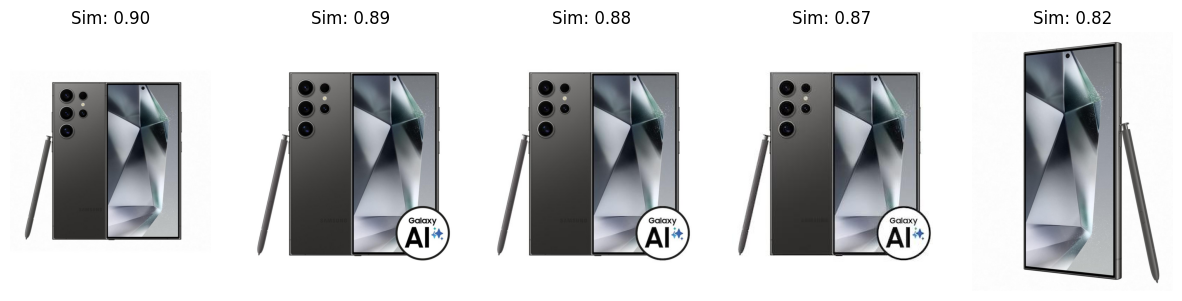

In [70]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Define bucket URL format for images
bucket_url = "https://storage.googleapis.com/mi-bucket-de-imagenes1/"

# Display top similar images using URLs
top_n = 5
print("Top similar images:")

plt.figure(figsize=(15, 5))

for i, (file_name, similarity_score) in enumerate(similarities[:top_n]):
    # Construct URL based on file name
    image_name = file_name.replace("embeddings/", "").replace(".npy", ".jpg")
    image_url = f"{bucket_url}{image_name}"

    print(f"{image_name}: Similarity = {similarity_score:.4f} | URL: {image_url}")

    # Fetch and display the image from the URL
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Check if the request was successful
        img = Image.open(BytesIO(response.content))

        plt.subplot(1, top_n, i + 1)
        plt.imshow(img)
        plt.title(f"Sim: {similarity_score:.2f}")
        plt.axis('off')
    except Exception as e:
        print(f"Could not load image from {image_url}. Error: {e}")

plt.show()